## Data Wrangling

In [1]:
import os
import cv2
import random
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Image

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, Precision, Recall
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image as k_image
from scikeras.wrappers import KerasClassifier
from keras.utils import to_categorical

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

2023-10-29 16:59:09.820444: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Create a list to hold data
data_list = []

# Define classes
data_path = '/Users/renatoboemer/code/edge/raw_data'
for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    
    # Check if the item is a directory
    if os.path.isdir(folder_path):
        for image in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image)
            label = folder
            data_list.append({'image_path': image_path, 'label': label})

# Convert list to DataFrame
data = pd.DataFrame(data_list)


In [3]:
data.head()

,image_path,label
0,/Users/renatoboemer/code/edge/raw_data/cloudy/...,cloudy
1,/Users/renatoboemer/code/edge/raw_data/cloudy/...,cloudy
2,/Users/renatoboemer/code/edge/raw_data/cloudy/...,cloudy
3,/Users/renatoboemer/code/edge/raw_data/cloudy/...,cloudy
4,/Users/renatoboemer/code/edge/raw_data/cloudy/...,cloudy


In [4]:
print('Labels: ', data.label.unique())
classes = data.label.unique()
data['label'].value_counts()

Labels:  ['cloudy' 'water' 'green_area' 'desert']


label
desert        1502
cloudy        1500
water         1500
green_area    1500
Name: count, dtype: int64

## Data Augumentation

The `desert` class is slightly imbalanced. To balance the dataset by augmenting the `desert` images, we will have to create an additional 
1500−1131=**369 images**. Let's apply a couple of data augmentation techniques to address this issue:
- rotation
- translation

Given these augmentations, each original `desert` image would generate 7 additional images (3 from rotations and 4 from translations).

To achieve 369 new images, we will need to process ⌈369/7⌉=53 original `desert` images.

In [ ]:
def rotate_image(image, angle):
    rows, cols, _ = image.shape
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1) 
    return cv2.warpAffine(image, M, (cols, rows))

def translate_image(image, x_shift, y_shift):
    rows, cols, _ = image.shape
    M = np.float32([[1, 0, x_shift], [0, 1, y_shift]])
    return cv2.warpAffine(image, M, (cols, rows))

In [ ]:
# Paths to desert images
desert_path = '/Users/renatoboemer/code/edge/raw_data/desert'
desert_image_paths = []

for image in os.listdir(desert_path):
    image_path = os.path.join(desert_path, image)
    desert_image_paths.append(image_path)
    

In [ ]:
# Shuffle the paths to randomize which images we are augmenting
random.shuffle(desert_image_paths)

augmented_images = []

for i, path in enumerate(desert_image_paths[:53]):
    image = cv2.imread(path)

    # Extracting the filename without extension
    filename = os.path.basename(path)
    base_filename, file_extension = os.path.splitext(filename)
    
    # Rotations
    cv2.imwrite(os.path.join(desert_path, f"{base_filename}_rotated_-15{file_extension}"), rotate_image(image, -15))
    cv2.imwrite(os.path.join(desert_path, f"{base_filename}_rotated_15{file_extension}"), rotate_image(image, 15))
    cv2.imwrite(os.path.join(desert_path, f"{base_filename}_rotated_30{file_extension}"), rotate_image(image, 30))
    
    # Translations
    cv2.imwrite(os.path.join(desert_path, f"{base_filename}_translated_right{file_extension}"), translate_image(image, 25, 0))
    cv2.imwrite(os.path.join(desert_path, f"{base_filename}_translated_left{file_extension}"), translate_image(image, -25, 0))
    cv2.imwrite(os.path.join(desert_path, f"{base_filename}_translated_down{file_extension}"), translate_image(image, 0, 25))
    cv2.imwrite(os.path.join(desert_path, f"{base_filename}_translated_up{file_extension}"), translate_image(image, 0, -25))


In [5]:
# Create a list to hold data
new_data_list = []

# Define classes
data_path = '/Users/renatoboemer/code/edge/raw_data'
for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    
    # Check if the item is a directory
    if os.path.isdir(folder_path):
        for image in os.listdir(folder_path):
            if image.endswith(('.jpg', '.png')):
                image_path = os.path.join(folder_path, image)
                label = folder
                new_data_list.append({'image_path': image_path, 'label': label})

In [6]:
# Convert list to DataFrame
df = pd.DataFrame(new_data_list)

# Print total count and count per label
print(f"Total images: {len(df)}")
print(df['label'].value_counts())

Total images: 6002
label
desert        1502
cloudy        1500
water         1500
green_area    1500
Name: count, dtype: int64


## Check an image

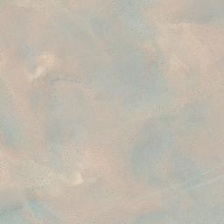

In [14]:
# Specify the path to your image
image_path = '/Users/renatoboemer/code/edge/raw_data/desert/desert(42).jpg'

# Read the image
img = cv2.imread(image_path)

# Check if the image was loaded successfully
if img is None:
    print("Error: Couldn't load the image.")
else:
    # Display the image in the notebook
    display(Image(data=cv2.imencode('.jpg', img)[1].tobytes()))


In [15]:
# Printing the size (height, width, channels)
print("image dimensions:", img.shape)

# Print image type
print(img.dtype)

image dimensions: (224, 224, 3)
uint8


Images are in 8-bit. Ideally, we would like to train our model using 32-bit to improve accuracy but it will not be possible.

## Resize & Normalize images

In [ ]:
def resize_images_in_directory(main_directory, target_size=(224, 224)):
    """
    Resize all images in the given directory and its sub-directories to the target size.

    :param main_directory: Path to the main directory.
    :param target_size: Tuple indicating target size (width, height).
    """
    
    resized = False  # Flag to indicate if any images were resized
    
    for root, dirs, files in os.walk(main_directory):
        for file in files:
            # Check if the file is an image
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)
                
                # Read and resize the image
                img = cv2.imread(image_path)
                if img is not None:  # Check if image was loaded successfully
                    resized_img = cv2.resize(img, target_size)
                    
                    # Save the resized image back to the same path, effectively replacing it
                    cv2.imwrite(image_path, resized_img)
                    resized = True  # Set the flag to indicate that at least one image was resized

    if resized:
        print("Resizing complete.")
    else:
        print("No images were resized.")


In [ ]:
main_directory = "/Users/renatoboemer/code/edge/raw_data"
resize_images_in_directory(main_directory, target_size=(224, 224))

In [ ]:
def normalize_images(main_directory):
    """
    Normalize pixel values of all images in the given directory and its sub-directories to the [0, 1] range.
    """
    
    normalized = False  # Initialize a flag to check if any images were normalized

    for root, dirs, files in os.walk(main_directory):
        for file in files:
            # Check if the file is an image (e.g., has a .jpg or .png extension).
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)

                # Read the image
                img = cv2.imread(image_path)
                if img is not None:  # Check if image was loaded successfully
                    # Normalize pixel values to the [0, 1] range
                    img_normalized = img.astype(np.float32) / 255.0

                    # Save the normalized image
                    cv2.imwrite(image_path, (img_normalized * 255))

                    normalized = True  # Set the flag to indicate that at least one image was normalized

    if normalized:
        print("Normalization complete.")
    else:
        print("Images not normalized.")


In [ ]:
main_directory = "/Users/renatoboemer/code/edge/raw_data"
normalize_images(main_directory)

## Train, Test, Split

In [17]:
from keras.utils import to_categorical

# Split data into train and validation+test sets
train_df, val_test_df = train_test_split(df, test_size=0.2, random_state=42)

# Further split validation+test set into validation and test sets
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=42)

In [18]:
label_mapping = {
    'green_area': 0,
    'water': 1,
    'desert': 2,
    'cloudy': 3
}

train_df['label'] = train_df['label'].map(label_mapping)
val_df['label'] = val_df['label'].map(label_mapping)
test_df['label'] = test_df['label'].map(label_mapping)

train_labels = train_df['label'].values
val_labels = val_df['label'].values
test_labels = test_df['label'].values

In [19]:
# One-hot encode the labels
train_labels_ohe = to_categorical(train_labels, num_classes=4)
val_labels_ohe = to_categorical(val_labels, num_classes=4)
test_labels_ohe = to_categorical(test_labels, num_classes=4)

In [20]:
print("Number of training samples: ", train_df.shape[0])
print("Number of validation samples: ", val_df.shape[0])
print("Number of testing samples: ", test_df.shape[0])

Number of training samples:  4801
Number of validation samples:  600
Number of testing samples:  601


In [21]:
from tensorflow.keras.preprocessing import image as k_image

def load_image(img_path):
    """Loads the image as a numpy array."""
    img = k_image.load_img(img_path)
    return k_image.img_to_array(img)

# Load images for training data
train_images = np.array([load_image(img_path) for img_path in train_df['image_path']])
train_labels = train_df['label'].values

# Load images for validation data
val_images = np.array([load_image(img_path) for img_path in val_df['image_path']])
val_labels = val_df['label'].values

# Load images for test data
test_images = np.array([load_image(img_path) for img_path in test_df['image_path']])
test_labels = test_df['label'].values


## Model

Satellites, especially those with onboard processing for tasks like image classification, have limitations when it comes to power, memory, and computational resources. This contrasts with the extensive resources available on the ground in data centers. Therefore, the convolutional neural networks (CNNs) employed on satellites tend to prioritise efficiency and resource conservation.

Given those constraints, I have decided to use [Keras MobileNet](https://keras.io/api/applications/mobilenet/). 

MobileNet is a class of efficient deep learning neural network architectures designed primarily for mobile and edge devices, rather than server-based applications. The goal of MobileNet is to provide a lightweight model that offers good performance while being computationally efficient, thereby allowing for real-time inference on devices with limited computational resources, such as a satellite 🛰️.

In [30]:
# # 1. Wrap model in a function
# def create_model(learning_rate=0.001, dropout_rate=0.2, dense_neurons=128):
#     input_shape = (224, 224, 3)
#     base_model = MobileNetV3Small(input_shape=input_shape, include_top=False, weights='imagenet')

#     x = GlobalAveragePooling2D()(base_model.output)
#     x = Dense(dense_neurons, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)
#     output = Dense(4, activation='softmax')(x)

#     model = Model(inputs=base_model.input, outputs=output)
#     model.compile(optimizer=Adam(learning_rate=learning_rate),
#                   loss=CategoricalCrossentropy(from_logits=False),
#                   metrics=['accuracy'])
#     return model

# # 2. Create a KerasClassifier
# model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=16, verbose=0)

# # 3. Define search space for BayesSearchCV
# search_space = {
#     'learning_rate': Real(0.0001, 0.01, prior='log-uniform'),
#     'dropout_rate': Real(0.1, 0.5)
#     'dense_neurons': Integer(64, 256)
# }

# # Initialise BayesSearchCV
# bayes_search = BayesSearchCV(estimator=model, 
#                              search_spaces=search_space,
#                              n_iter=10, 
#                              cv=3, 
#                              n_jobs=-1, 
#                              verbose=1)


In [37]:
# bayes_search.fit(train_images, train_labels_ohe,)

# best_params = bayes_search.best_params_
# best_params

In [36]:
import optuna
from optuna.integration import KerasPruningCallback
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.optimizers import Adam

def create_model(trial):
    # Suggest values for the hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.01, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.3)
    dense_neurons = trial.suggest_int('dense_neurons', 64, 256)
    
    # Build the model architecture
    base_model = MobileNetV3Small(input_shape=(224, 224, 3), include_top=False, weights='imagenet', )
    base_model.trainable = False  # Freeze the convolutional base
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(dropout_rate)(x)
    x = Dense(dense_neurons, activation='relu')(x)
    predictions = Dense(4, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def objective(trial):
    model = create_model(trial)

    # Add a callback for pruning.
    callbacks = [KerasPruningCallback(trial, 'val_accuracy')]

    # Train the model
    history = model.fit(
        train_images, train_labels_ohe,
        validation_data=(val_images, val_labels_ohe),
        shuffle=True,
        batch_size=32,
        epochs=10,
        callbacks=callbacks,
    )
    
    # Evaluate the model accuracy on the validation set
    val_accuracy = model.evaluate(val_images, val_labels_ohe)[1]
    return val_accuracy

# Create a study object and specify the direction is 'maximize'.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, timeout=600)

# Print the result
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print(f"Best hyperparameters: {trial.params}")


[I 2023-10-29 17:33:32,208] A new study created in memory with name: no-name-394f211d-c442-43f8-92b3-8dd0db597a67
/var/folders/0z/4gxpxvr90sg_nm735wh2pcw00000gn/T/ipykernel_42138/879048177.py:33: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function that can be used instead: :class:`~optuna_integration.TFKerasPruningCallback`
  callbacks = [KerasPruningCallback(trial, 'val_accuracy')]


Epoch 1/10
151/151 [==============================] - 53s 323ms/step - loss: 0.1218 - accuracy: 0.9665 - val_loss: 0.0323 - val_accuracy: 0.9933
Epoch 2/10
151/151 [==============================] - 48s 320ms/step - loss: 0.0363 - accuracy: 0.9875 - val_loss: 0.0106 - val_accuracy: 0.9983
Epoch 3/10
151/151 [==============================] - 50s 329ms/step - loss: 0.0179 - accuracy: 0.9956 - val_loss: 0.0124 - val_accuracy: 0.9967
Epoch 4/10
151/151 [==============================] - 50s 332ms/step - loss: 0.0204 - accuracy: 0.9948 - val_loss: 0.0081 - val_accuracy: 1.0000
Epoch 5/10
151/151 [==============================] - 64s 422ms/step - loss: 0.0178 - accuracy: 0.9940 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 6/10
151/151 [==============================] - 50s 331ms/step - loss: 0.0137 - accuracy: 0.9958 - val_loss: 0.0085 - val_accuracy: 0.9967
Epoch 7/10
151/151 [==============================] - 52s 342ms/step - loss: 0.0136 - accuracy: 0.9965 - val_loss: 0.0055 - val_ac

[I 2023-10-29 17:42:21,261] Trial 0 finished with value: 0.996666669845581 and parameters: {'learning_rate': 0.002687672047407516, 'dropout_rate': 0.14934293517802494, 'dense_neurons': 73}. Best is trial 0 with value: 0.996666669845581.


Epoch 1/10
151/151 [==============================] - 54s 323ms/step - loss: 0.1358 - accuracy: 0.9517 - val_loss: 0.0299 - val_accuracy: 0.9917
Epoch 2/10
151/151 [==============================] - 47s 309ms/step - loss: 0.0351 - accuracy: 0.9890 - val_loss: 0.0231 - val_accuracy: 0.9950
Epoch 3/10
151/151 [==============================] - 56s 372ms/step - loss: 0.0359 - accuracy: 0.9879 - val_loss: 0.0391 - val_accuracy: 0.9883
Epoch 4/10
151/151 [==============================] - 51s 336ms/step - loss: 0.0268 - accuracy: 0.9917 - val_loss: 0.0205 - val_accuracy: 0.9950
Epoch 5/10
151/151 [==============================] - 53s 352ms/step - loss: 0.0419 - accuracy: 0.9900 - val_loss: 0.0063 - val_accuracy: 1.0000
Epoch 6/10
151/151 [==============================] - 49s 323ms/step - loss: 0.0381 - accuracy: 0.9915 - val_loss: 0.0235 - val_accuracy: 0.9933
Epoch 7/10
151/151 [==============================] - 50s 329ms/step - loss: 0.0178 - accuracy: 0.9954 - val_loss: 0.0126 - val_ac

[I 2023-10-29 17:51:11,892] Trial 1 finished with value: 0.9950000047683716 and parameters: {'learning_rate': 0.00924571520427982, 'dropout_rate': 0.17860648246386135, 'dense_neurons': 185}. Best is trial 0 with value: 0.996666669845581.


Accuracy: 0.996666669845581
Best hyperparameters: {'learning_rate': 0.002687672047407516, 'dropout_rate': 0.14934293517802494, 'dense_neurons': 73}


In [ ]:
# Build the optimised model
base_model = MobileNetV3Small(input_shape=(224, 224, 3), include_top=False, weights='imagenet', )
base_model.trainable = False  # Freeze the convolutional base
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.14934293517802494)(x)
x = Dense(73, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
    
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.002687672047407516),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# model.summary()

In [ ]:
history = model.fit(train_images, train_labels_ohe, 
                    validation_data=(val_images, val_labels_ohe), 
                    epochs=10, 
                    batch_size=160)


In [ ]:
def plot_loss_accuracy(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

plot_loss_accuracy(history)

In [ ]:
loss, test_accuracy = model.evaluate(test_images, test_labels_ohe)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")


## First version

In [ ]:
# # Define input shape
# input_shape = (224, 224, 3)

# # Create MobileNetV3-Small model
# base_model = MobileNetV3Small(input_shape=input_shape, include_top=False, weights='imagenet')

# # Add custom classification layers on top
# x = GlobalAveragePooling2D()(base_model.output)
# x = Dense(128, activation='relu')(x)
# output = Dense(4, activation='softmax')(x)

# # Create the final model
# model = Model(inputs=base_model.input, outputs=output)

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=0.001),
#               loss=CategoricalCrossentropy(from_logits=False),
#               metrics=['accuracy', 'Precision', 'Recall'])